# Loading ECCO V4 Netcdf Files

Ian Fenty, updated 2025-05-20

## Introduction

This tutorial covers different approaches to loading ECCO V4 Netcdf files that are stored on your local disk and "in the cloud" in different AWS "S3" Buckets. 

ECCO V4r4 files are stored in an S3 bucket managed by NASA's PO.DAAC. Accessing these files requires setting up a NASA EarthData credential. These files can be accessed from anywhere.

ECCO V4r5 files are stored in a different bucket. Accessing these files doesn't require a NASA EarthData credential. These files are best accessed from cloud-based computer (which we have for the summer school).

The tutorial also covers the concepts
* fully loading files into memory [slow ] vs. lazy-loading files [much faster]
* 'direct' cloud access [slow] vs. 'referenced-based' cloud access [much faster]


In [2]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
# sys.path.insert(0,join(user_home_dir,'xmovie'))

In [21]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import xgcm
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea
import fsspec
import zarr

from finite_differences import *
from time_series_analysis import *

from grid_utils import *
from heat_budgets import *

from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:45007")
# client = Client()
client.ncores
client.restart()
client

<Client: 'tcp://127.0.0.1:45007' processes=0 threads=0, memory=0 B>

In [4]:
from finite_differences import *
# from xmovie import Movie


In [120]:
def custom_plotfunc(ds, ax, fig, tt, *args, **kwargs):
    # Define station location for timeseries
    levels = np.arange(-4, 4.1, 0.5)

    ds.isel(time=tt).plot.contourf(
    x = "XC", y = "YC",
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "label":"[deg C]"},
    vmin=-4, vmax=4,
    levels = levels, 
    cmap = "bwr", 
    extend = "both"
    )
    
    ax.set_extent([-124, -100, 20, 40], crs=ccrs.PlateCarree())
    ax.coastlines(color = "grey")  # cartopy function
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      color='gray', alpha=0.0, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_aspect(1)
    # ^ This is not strictly necessary, but otherwise a warning will be raised.

In [121]:
ds = xr.open_dataset("data/ptemp_ccs_timeseries.nc")
ds_noseasonal = remove_seasonal_cycle(ds)

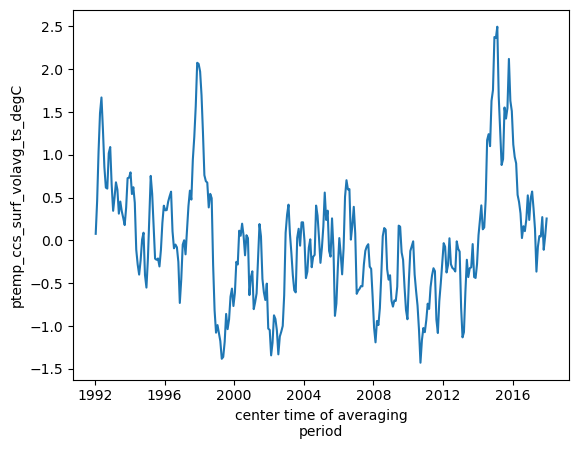

In [122]:
ds_noseasonal["ptemp_ccs_surf_volavg_ts_degC"].plot()

2015-02-15T00:00:00.000000000


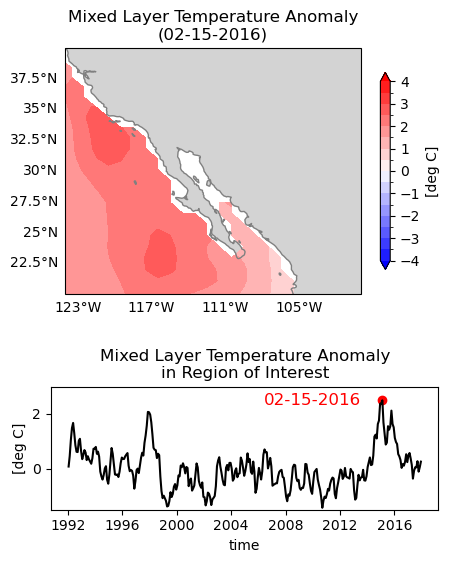

In [147]:
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature

where_max = ds_noseasonal["ptemp_ccs_surf_volavg_ts_degC"].argmax().values
value_where_max = ds_noseasonal["ptemp_ccs_surf_volavg_ts_degC"][where_max].values
time_where_max = ds_noseasonal.time[where_max].values
print(time_where_max)

fig = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1],hspace = 0.5)
ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

custom_plotfunc(ds_noseasonal["ptemp_ccs_surf_volavg_2D_ts_degC"].isel(tile = 10), 
                ax_map, fig, where_max)
ax_map.set_title("Mixed Layer Temperature Anomaly\n(02-15-2016)")      
ax_ts = fig.add_subplot(gs[1])


ds_noseasonal["ptemp_ccs_surf_volavg_ts_degC"].plot(ax = ax_ts, c = "k")
ax_ts.scatter(time_where_max, value_where_max, c = "r")

ax_ts.text(
    0.55, 0.85,                 # (x, y) in axes coords
    "02-15-2016",       # your annotation text
    transform=ax_ts.transAxes,   # interpret xy in axes fraction
    fontsize=12,
    color = "red"
    # bbox=dict(boxstyle="round,pad=0.3", alpha=0.2)
)

ax_ts.set_title("Mixed Layer Temperature Anomaly\nin Region of Interest")
ax_ts.set_xlabel("time")
ax_ts.set_ylabel("[deg C]")
ax_ts.set_ylim(-1.5, 3)

fig.savefig("plots/Temperature_Anomaly_Snapshot.png", dpi = 200)

In [ ]:
# mov = Movie(ds_surface_Cali_anom.THETA.resample(time='1W').interpolate('linear').isel(time = slice(0,None)), custom_plotfunc)
# mov.save('movie_THETA.mp4', progress=True, overwrite_existing = True, framerate=10)